### Counterfactual & Synthetic Control Method: Causal Inference with Instrumented Principal Component Analysis
`Cong Wang`

In [27]:
import pandas as pd
import numpy as np
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

import matplotlib.pyplot as plt
import seaborn as sns

from src.data_gen import data_gen, data_gen_xu

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [28]:
# matrix left/right division (following MATLAB function naming)
_mldivide = lambda denom, numer: sla.lstsq(np.array(denom), np.array(numer))[0]
_mrdivide = lambda numer, denom: (sla.lstsq(np.array(denom).T, np.array(numer).T)[0]).T

### 1. Framework
---
+ $Y_{it}$ is the outcome.

+ Total number of units $N=N_{co} + N_{tr}$

+ Total number of time periods $T=T_0 + T_1$

+ Staggered treatment adoption

`Assumption 1.` Functional form:

\begin{equation}
\begin{align*}

&y_{it} = d_{it} \circ \delta_{it} + \Lambda_{it}F_{t} + \epsilon_{it}, \\
&\Lambda_{it} = X'_{it}\Gamma + \eta_{it}

\end{align*}
\end{equation}

+ $y_{it}$ is scaler of targeted outcome

+ $d_{it}$ indicates units with or without treatment

+ $\delta_{it}$ indicates treatment effect, which is heterogenous (across units and periods)

+ $X_{it}$ is a $L\times 1$ vector of observed covariates

+ $\Gamma$ is a $L\times K$ transforming matrix

+ $\Lambda_{it}$ is a $1 \times K$ vector of factor loadings

+ $F_t$ is a $K\times 1$ vector of unobserved common factors

+ $\Lambda_{it}F_{t}$ is the factor component

### 2. Generate data
---

In [29]:
# Number of factors and time periods
K = 3
T0 = 20
T1 = 10
# number of total covariates
L = 10
# Number of control and treated units

N_co = 45
N_tr = 5
# drift for treated units
drift = 2
# similarity parameter in Xu
w = 0.8

# random seed
np.random.seed(39)
# gen data with my data generating process
df = data_gen(T0, T1, N_co, N_tr, L, K, drift)
df['const'] = 1

# gen data with Yiqing Xu data generating process
#df = data_gen_xu(T0, T1, N_co, N_tr, L, K, w)

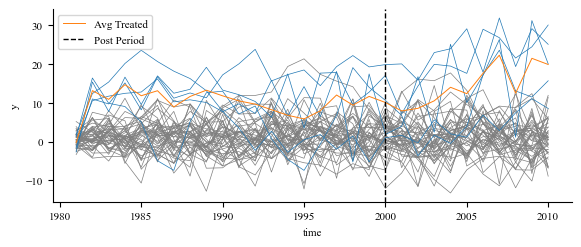

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6.7, 2.5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[7], linewidth=0.5)

sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', ax=ax, units='id', estimator=None, color=colors[0], linewidth=0.5)

ax.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], linewidth=0.7, label='Avg Treated')
ax.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1, label='Post Period')
ax.legend()

sns.despine()

### 3. Estimation
---

**Step 1.** Estimate $\hat{\Gamma}$ and $\hat{F}$ with only control units across the whole time periods.


IPCA is estimated as a least squares problem that minimizes the sample sum of squared errors (SSE) over parameters $\Gamma,  F_t$:

$$
\min_{\Gamma, F_t} \sum_{i,t} (y_{i,t} - X_{i,t} \Gamma F_t)^2 . \quad \forall i \in N_{co}, \forall t \in T
$$

We use an Alternating Least Squares (ALS) method for the numerical solution of the optimization because, unlike PCA, the IPCA optimization problem does not have a solution through an eigen-decomposition.

given $F_t$, the optimizing $\Gamma$ (vectorized as $\gamma$) is solved with pooled panel OLS of $y_{i,t}$ onto $L \times K$ regressors, $X_{i,t} \otimes F_t^T$

$$
\hat{\Gamma}:=\arg\min_{\gamma} \sum_{i,t} (y_{i,t} - X_{i,t} \Gamma F_t)^2 = \left( \sum_{i,t} (X_{i,t}^T \otimes F_t) (X_{i,t} \otimes F_t^T) \right)^{-1} \left( \sum_{i,t} (X_{i,t}^T \otimes F_t) y_{i,t} \right).
$$

Given any $\Gamma$, factors $F_t$ are $t$-separable and solved with cross-sectional OLS for each $t$:
$$
\hat{F}_t := \arg\min_{F_t} \sum_{i} (y_{i,t} - X_{i,t} \Gamma F_t)^2 = (\Gamma^T X_t^T X_t \Gamma)^{-1} \Gamma^T X_t^T Y_t.
$$

In [31]:
# get a list of covariates
covariates = df.columns[7:].values

# build a function to prepare matrix
def prepare_matrix(df, id, time, outcome, covariates):
    Y = df.pivot(index=id, columns=time, values=outcome).values
    X = np.array([df.pivot(index=id, columns=time, values=var).values for var in covariates]).transpose(1, 2, 0)
    return Y, X

# prepare matrix
Y0, X0 = prepare_matrix(df.query("tr_group==0"), 'id', 'time', 'y', covariates)

In [32]:
# K: number of factors
K = 3
# dimensions
N, T, L = X0.shape

# step a: initial guess
svU, svS, svV = ssla.svds(Y0, K)
svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV) # reverse the order from largest to smallest
# initial guess for F
F0 = np.diag(svS) @ svV
# initial value for Gama to be updated
Gama0 = np.zeros((L, K))

# define a function to conduct ALS estimation
def als_est():
    # step b: with F fixed, estimate Gama
    vec_len = len(covariates)*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T):
        for i in range(N_co):
            X0_slice = X0[i, t, :] # X_it is Lx1 vector for each i and t
            Ft_slice = F0[:, t] # F_t is Kx1 vector for each t
            # compute kronecker product
            kron_prod = np.kron(X0_slice, Ft_slice)
            # update numer and denom
            numer += kron_prod * Y0[i, t]
            denom += np.outer(kron_prod, kron_prod)

    # solve for gama using matrix left division
    Gama1 = _mldivide(denom, numer).reshape(len(covariates), K)

    # step c: with Gama fixed, estimate F
    F1 = np.zeros((K, T))
    for t in range(T):
        denom = Gama1.T@X0[:,t,:].T@X0[:,t,:]@Gama1
        numer = Gama1.T@X0[:,t,:].T@Y0[:,t]
        F1[:, t] = _mldivide(denom, numer)

    return Gama1, F1

# step d: iterate until convergence
MaxIter, MinTol = 100, 1e-6
tol, iter = float('inf'), 0
while iter < MaxIter and tol > MinTol:
    Gama1, F1 = als_est()
    tol_Gama = abs(Gama1 - Gama0).max()
    tol_F = abs(F1 - F0).max()
    tol = max(tol_Gama, tol_F)
    print(f'iter: {iter}, tol_Gama: {tol_Gama}, tol_F: {tol_F}')
    F0, Gama0 = F1, Gama1
    iter += 1

iter: 0, tol_Gama: 0.054162873427376156, tol_F: 41.63688979346292
iter: 1, tol_Gama: 0.0058013669163880024, tol_F: 28.06617737442037
iter: 2, tol_Gama: 0.004470358246666441, tol_F: 9.272801521705262
iter: 3, tol_Gama: 0.0010949401343212685, tol_F: 3.3705590217125376
iter: 4, tol_Gama: 0.0004196093584068932, tol_F: 1.9437744967402537
iter: 5, tol_Gama: 0.0003141617389958336, tol_F: 1.3150594582373785
iter: 6, tol_Gama: 0.00027682921378913757, tol_F: 0.9466416427368998
iter: 7, tol_Gama: 0.00022229128152106113, tol_F: 0.695245616085721
iter: 8, tol_Gama: 0.00017198843791678149, tol_F: 0.5127945267650134
iter: 9, tol_Gama: 0.0001304225796534518, tol_F: 0.3777871743739283
iter: 10, tol_Gama: 9.76499096556312e-05, tol_F: 0.2775936532462424
iter: 11, tol_Gama: 7.247772850640932e-05, tol_F: 0.20342736258826477
iter: 12, tol_Gama: 5.346382607228535e-05, tol_F: 0.14873713061255955
iter: 13, tol_Gama: 3.926413346307632e-05, tol_F: 0.10855400731484366
iter: 14, tol_Gama: 2.8744059406091843e-05, t

In [33]:
# define a function to compute r2
def _calc_r2(r_act, r_fit):
    '''
    compute r2 of fitted values vs actual
    '''
    sumsq = lambda x: x.dot(x)
    sse = sumsq(r_act.flatten() - r_fit.flatten())
    sst = sumsq(r_act.flatten())
    return 1. - sse / sst

In [34]:
# compute the fitted value for control units 
Y0_hat = np.zeros((N, T))
for t in range(T):
    for i in range(N):
        Y0_hat[i, t] = X0[i, t, :] @ Gama1 @ F1[:, t]

In [35]:
# check the fit
print(f'The in sample fit is {_calc_r2(r_act=Y0, r_fit=Y0_hat)}')


The in sample fit is 0.9524218761143586


**Step 2.** estimate $\Gamma$ for the group of treated units 

Since we have estimated $\hat{F}$ with the control units, the next step we need to estimate $\hat{\Gamma}$ for the treated units, following the same minimization problem but with only treated units prior the treatment.

$$
\min_{\Gamma, F_t} \sum_{i,t} (y_{i,t} - X_{i,t} \Gamma F_t)^2 . \quad \forall i \in N_{tr}, \forall t \in T_0
$$

$$
\hat{\Gamma}_{tr}:=\arg\min_{\gamma} \sum_{i,t} (y_{i,t} - X_{i,t} \Gamma \hat{F_t})^2 = \left( \sum_{i,t} (X_{i,t}^T \otimes \hat{F_t}) (X_{i,t} \otimes \hat{F_t}^T) \right)^{-1} \left( \sum_{i,t} (X_{i,t}^T \otimes \hat{F_t}) y_{i,t} \right).
$$

In [36]:
# prepare the treated units before the treatment
Y10, X10 = prepare_matrix(df.query("tr_group==1 & post_period==0"), 'id', 'time', 'y', covariates)

In [37]:
# step 2: use treated units before treatment to estimate the Gamma
vec_len = len(covariates)*K
numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
for t in range(T0):
    for i in range(N_tr):
        X0_slice = X10[i, t, :] # X_it is Lx1 vector for each i and t
        Ft_slice = F1[:, t] # F_t is Kx1 vector for each t
        # compute kronecker product
        kron_prod = np.kron(X0_slice, Ft_slice)
        # update numer and denom
        numer += kron_prod * Y10[i, t]
        denom += np.outer(kron_prod, kron_prod)
# solve for gama using matrix left division
Gama_tr = _mldivide(denom, numer).reshape(len(covariates), K)

**Step 3.** Normalization

In [38]:
# cholesky decomposition
R1 = sla.cholesky(Gama_tr.T @ Gama_tr)

# singular value decomposition
R2, _, _ = sla.svd(R1 @ F1 @ F1.T @ R1)

# matrix division
Gama_tr_norm = _mrdivide(Gama_tr, R1).dot(R2)
F1_norm = _mldivide(R2, R1 @ F1)

**Step 4.** calculate treated counterfactuals based on $\tilde{F}, \hat{\Gamma}_{tr}$

$$
\hat{Y}_{it}(0) = X_{i,t} \hat{\Gamma}_{tr} \tilde{F}_t \quad i \in T_{tr}, \, t \in T.
$$

In [39]:
# prepare the treated units to compute the counterfactuals
Y1, X1 = prepare_matrix(df.query("tr_group==1"), 'id', 'time', 'y', covariates)

In [40]:
# compute counterfactual for treated units all time periods
Y_syn = np.zeros((N_tr, T))
for i in range(N_tr):
    for t in range(T):
        Y_syn[i, t] = X1[i, t, :]@Gama_tr_norm@F1_norm[:, t]

# compute the actual treatment effect
eff = df.query("tr_group==1").groupby('time').eff.mean()

# compute the estimated treatment effect as the difference between the synthetic control and the treated units
residuals = np.mean(df.query("tr_group==1").pivot(index='id', columns='time', values='y')-Y_syn, axis=0)

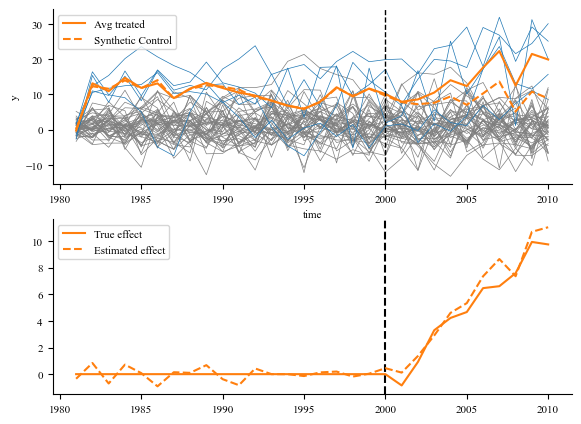

In [41]:
# plot the synthetic control with the actual outcomes of all units

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[7], linewidth=0.5)
sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], label='Avg treated')
ax1.plot(df.time.unique(), Y_syn.mean(axis=0), color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.legend()

# plot the estimated treatment effect
ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--')
ax2.plot(eff, color=colors[1], label='True effect')
ax2.plot(residuals, color=colors[1], linestyle='--', label='Estimated effect')
ax2.legend()

sns.despine()

In [42]:
# with the class fucntion we build to cover the same result
from src.CSC_IPCA import CSC_IPCA
# issue the model
model = CSC_IPCA()
# fit the model
model.fit(df, 'id', 'time', 'y', 'treated', covariates, 3)
# predict the synthetic outcome
y1_hat = model.predict()
# compute the estimated treatment effect
hat_residual = np.mean(df.query("tr_group==1").pivot(index='id', columns='time', values='y')-y1_hat, axis=0)

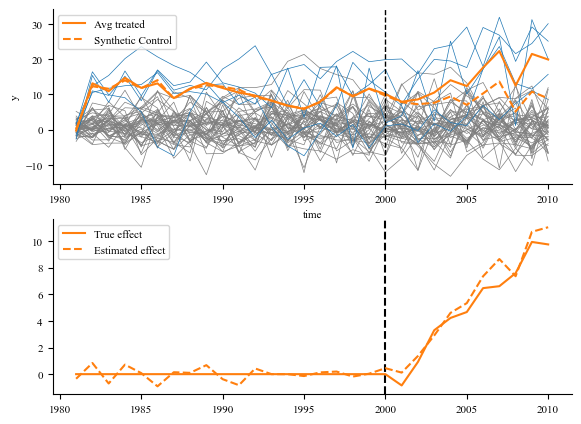

In [43]:
# plot the synthetic control with the actual outcomes of all units

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[7], linewidth=0.5)
sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], label='Avg treated')
ax1.plot(df.time.unique(), y1_hat.mean(axis=0), color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.legend()

# plot the estimated treatment effect
ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--')
ax2.plot(eff, color=colors[1], label='True effect')
ax2.plot(hat_residual, color=colors[1], linestyle='--', label='Estimated effect')
ax2.legend()

sns.despine()

In [49]:
# check if the factor is orthogonal 
model.F @ model.F.T

array([[ 1.55302051e+02, -2.69720484e-01,  2.27362317e+00],
       [-2.69720484e-01,  3.94644783e+00, -4.66618281e-02],
       [ 2.27362317e+00, -4.66618281e-02,  1.76980024e+00]])

In [50]:
# check if the Gamma is orthonormal 
model.Gama.T @ model.Gama

array([[ 1.00000000e+00, -7.35047492e-17, -9.72676191e-17],
       [-7.35047492e-17,  1.00000000e+00, -5.13251100e-16],
       [-9.72676191e-17, -5.13251100e-16,  1.00000000e+00]])

### GSC -- Interactive Fixed Effect Method
`Yiqing Xu`

### 1. Frame work

$$
Y_{it} = \delta_{it}D_{it} + x'_{it}\beta + \lambda'_{i}f_{t} + \epsilon_{it},
$$

+ $D_{it}$ indicates treatment status

+ $\delta_{it}$ indicates treatment heterogeneity is allowed (across units and periods)

+ $x_{it}$ contains $k\times 1$ vector of observed covariates

+ $\beta$ is a $k\times 1$ unknown factors, it is constant across units and periods

+ $f_t$ is a $r\times 1$ unobserved common factors, and $\lambda_i$ is an $r\times1$ factor loadings

+ $\lambda'_{i}f_{t}$ is the factor component

### 2. Estimation
--- 
**Step 1.** estimate an IFE model using only the control group data and obtain $\hat{\beta}, \hat{F}, \hat{\Lambda}_{co}$

$$
 (\hat{\beta}, \hat{F}, \hat{\Lambda}_{co}) = \underset{\tilde{\beta}, \tilde{F}, \tilde{\Lambda}_{co}}{\arg\min} \sum_{i \in C} (Y_i - X_i\tilde{\beta} - \tilde{F}\tilde{\lambda}_i)'(Y_i - X_i\tilde{\beta} - \tilde{F}\tilde{\lambda}_i) \\

\text{s.t. } \tilde{F}'\tilde{F}/T = I_r \quad \text{ and } \quad \tilde{\Lambda}_{co}'\tilde{\Lambda}_{co} = \text{diagonal}.
$$

Specifically:
$$
\hat{\beta}(F, \Lambda) = \left( \sum_{i=1}^{N_{co}} X'_i X_i \right)^{-1} \sum_{i=1}^{N_{co}} X'_i \left( Y_i - F \Lambda_i \right),
$$

And then use sigular value decomposation to get F and $\lambda_i$.

In [44]:
# specify the number of factors
K = 3

# Initialize parameters
N, T, L = X0.shape
F0 = np.random.randn(T, K)
lambda0 = np.random.randn(N, K)
beta0 = np.zeros(L)

# define a function to conduct the ALS estimation
def als_est(X, Y, F0, lambda0, K):
    N, T, L = X.shape
    # flatten Y and X
    y = Y.flatten()
    x = X.reshape(N*T, L)

    # compute beta
    denom = x.T @ x
    numer = x.T @ (y - (lambda0@F0.T).flatten())
    beta1 = _mldivide(denom, numer)

    # compute lambda1, F1
    residual = (y - x@beta1).reshape(N, T)
    M = (residual.T @ residual) / (N*T)
    s, v, d = sla.svd(M)
    F1 = s[:, :K]
    lambda1 = residual @ F1 / T

    return beta1, lambda1, F1

# the convergence criterion is different, here the author uses the difference of the objective function in current and previous iteration
prev_obj = float('inf')
MaxIter, MinTol = 100, 1e-6
tol, iter = float('inf'), 0
while iter < MaxIter and tol > MinTol:
    beta1, lambda1, F1 = als_est(X0, Y0, F0, lambda0, K)

    # compute the objective function
    obj_fun = np.linalg.norm(Y0 - X0@beta1 - lambda1@F1.T)
    tol = abs(obj_fun - prev_obj)
    
    beta0, lambda0, F0 = beta1, lambda1, F1
    prev_obj = obj_fun
    print(f'iter: {iter}, tol: {tol}')
    iter += 1

iter: 0, tol: inf
iter: 1, tol: 0.37628654305845544
iter: 2, tol: 0.00012208307875027913
iter: 3, tol: 6.462090595960035e-08


**Step 2.** estimate factor loadings for each treated unit by minimizing the mean squared error of the predicted treated outcome in pretreatment periods:

\begin{align*}
\hat{\lambda}_i &= \underset{\tilde{\lambda}_i}{\arg\min} (Y_i^0 - X_i^0 \hat{\beta} - \hat{F}_0 \tilde{\lambda}_i)'(Y_i^0 - X_i^0 \hat{\beta} - \hat{F}_0 \tilde{\lambda}_i) \\
&= (\hat{F}_0' \hat{F}_0)^{-1} \hat{F}_0'(Y_i^0 - X_i^0 \hat{\beta}), \quad i \in \mathcal{T},
\end{align*}

In [45]:
# step 2: use treated units before treatment to estimate the lambda
Y10, X10 = prepare_matrix(df.query("tr_group==1 & post_period==0"), 'id', 'time', 'y', covariates)

# solve it by formula
numer = F1[:T0, :].T@(Y10 - (X10@beta1)).T
denom = F1[:T0, :].T@F1[:T0, :]
lambda1 = _mldivide(denom, numer).T

**Step 3.** calculate treated counterfactuals based on $\hat{\beta}, \hat{F}, \hat{\lambda}_i$

$$
\hat{Y}_{it}(0) = x'_{it} \hat{\beta} + \hat{\lambda}'_{i} \hat{f}_t \quad i \in \mathcal{T}, \, t > T_0.
$$

In [46]:
# prepare the matrix to compute the counterfactuals
Y1, X1 = prepare_matrix(df.query("tr_group==1"), 'id', 'time', 'y', covariates)

# compute counterfactual for treated units all time periods
Y_syn = X1@beta1 + lambda1@F1.T

# compute the residuals between the synthetic control and the treated units
residuals = np.mean(df.query("tr_group==1").pivot(index='id', columns='time', values='y')-Y_syn, axis=0)

# compute true eff
eff = df.query("tr_group==1").groupby('time').eff.mean()

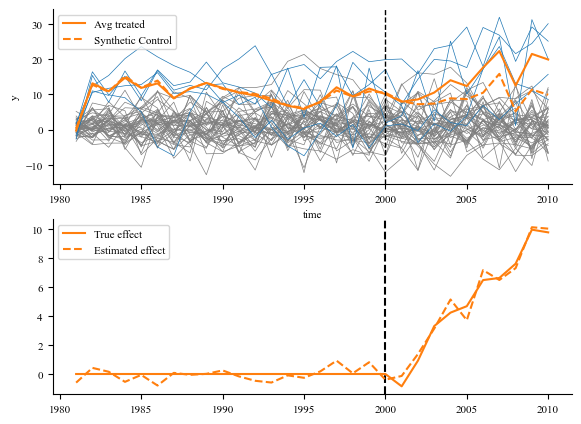

In [47]:
# plot the synthetic control with the actual outcomes of all units

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("tr_group==0"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[7], linewidth=0.5)
sns.lineplot(data=df.query("tr_group==1"), x='time', y='y', units='id', estimator=None, ax=ax1, legend=False, color=colors[0], linewidth=0.5)
ax1.plot(df.query("tr_group==1").groupby('time').y.mean(), color=colors[1], label='Avg treated')
ax1.plot(df.time.unique(), Y_syn.mean(axis=0), color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--', linewidth=1)
ax1.legend()

# plot the estimated treatment effect
ax2.axvline(x=df.query("post_period==0").time.max(), color='black', linestyle='--')
ax2.plot(eff, color=colors[1], label='True effect')
ax2.plot(residuals, color=colors[1], linestyle='--', label='Estimated effect')
ax2.legend()

sns.despine()